In [1]:
# importing stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# loading dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
x_train.shape

(60000, 28, 28, 1)

In [5]:
x_test.shape

(10000, 28, 28, 1)

In [6]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

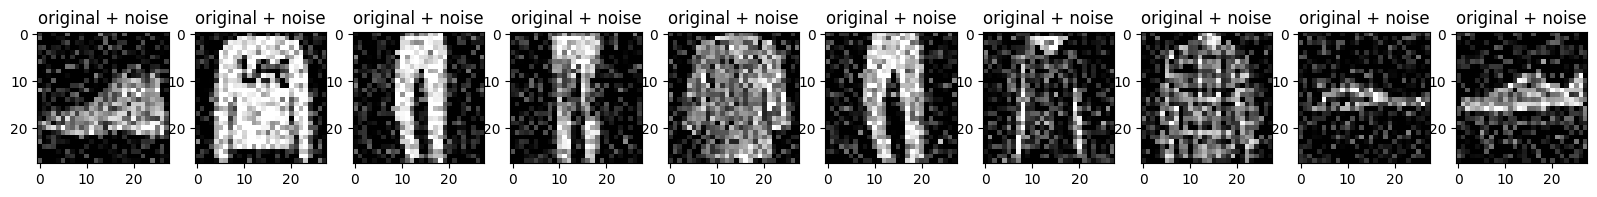

In [7]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [8]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 91s 47ms/step - loss: 0.0187 - val_loss: 0.0108
Epoch 2/10
1875/1875 [==============================] - 87s 46ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 3/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 4/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 5/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 6/10
1875/1875 [==============================] - 82s 43ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 7/10
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 8/10
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 9/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/10
1875/1875 [==============================] - 90s 48m

In [11]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

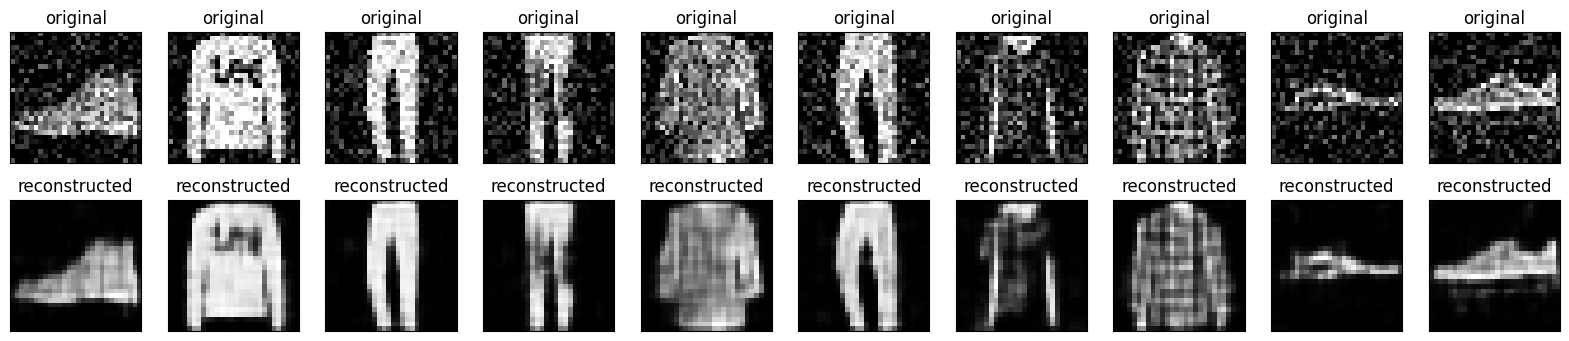

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()